# Load Data

In [1]:
from datasets import load_dataset

In [2]:
dataset = load_dataset("sam-paech/mmlu-pro-nomath-sml")

In [3]:
dataset

DatasetDict({
    test: Dataset({
        features: ['question_id', 'question', 'options', 'answer', 'answer_index', 'cot_content', 'category', 'src'],
        num_rows: 2639
    })
    validation: Dataset({
        features: ['question_id', 'question', 'options', 'answer', 'answer_index', 'cot_content', 'category', 'src'],
        num_rows: 70
    })
})

In [4]:
# dataset["test"]
df = dataset["test"].to_pandas()

In [11]:
df

,question_id,question,options,answer,answer_index,cot_content,category,src
0,70,"Typical advertising regulatory bodies suggest,...","[Safe practices, Fear, Jealousy, Trivial, Unsa...",I,8,,business,ori_mmlu-business_ethics
1,71,Managers are entrusted to run the company in t...,"[Shareholders, Diligence, Self-interest, Share...",F,5,,business,ori_mmlu-business_ethics
2,72,There are two main issues associated with ____...,"[Down, Autonomy, Remuneration, Benefit, Down, ...",J,9,,business,ori_mmlu-business_ethics
3,73,_______ locate morality beyond the sphere of r...,"[Ethical egoism, Ethics of duty, Postmodern et...",C,2,,business,ori_mmlu-business_ethics
4,74,Some of key differences between Islamic finan...,"[Interest, Certain, Assured, Both tangible and...",G,6,,business,ori_mmlu-business_ethics
...,...,...,...,...,...,...,...,...
2634,12182,Let X be the random variable denoting the resu...,"[f(0) = (0) and f(1) = (1), f(0) = (1/2) and f...",B,1,,engineering,stemez-ElectronicCommunications
2635,12192,The resistance in the circuit of the moving co...,"[Low., Very low., High., Almost zero.]",C,2,,engineering,ori_mmlu-electrical_engineering
2636,12193,A Binary number system has how many digits.,"[0, 1, 2, 10]",C,2,,engineering,ori_mmlu-electrical_engineering
2637,12194,Speed of data transmission in 4-G network of t...,"[10 gbps - 100 gbps., 50 mbps - 500 mbps., 2 m...",D,3,,engineering,ori_mmlu-electrical_engineering


# Experiment!

In [77]:
import jsonlines
import os

from llm_council.processors.council_service import (
    get_default_council_service,
    CouncilService,
)

OUTDIR = "data/mmlu_pro.n100.mini.run2"

CHOICE_MAP = {
    0: "A",
    1: "B",
    2: "C",
    3: "D",
    4: "E",
    5: "F",
    6: "G",
    7: "H",
    8: "I",
    9: "J",
    10: "K", 
    11: "L", 
    12: "M", 
}

def get_options_string(options):
    str = ""
    option_strings = []
    for i, option in enumerate(options):
        option_strings.append(f"{CHOICE_MAP[i]}: {option}")
    return ", ".join(option_strings)
    

def get_answer_string(options, answer_index):
    return CHOICE_MAP[answer_index] + ": " + options[answer_index]
    

STRUCTURED_OUTPUT_JUDGE_GROUND_TRUTH_COT_FIRST = '''The following multiple-choice question was asked to a {role}.

Question: {question}

Options: {options}

The {role}'s answer was:
{answer}

Please assess whether the {role} is correct or incorrect, or if you do not know. 

Think step by step and then decide on your final answer. Your final answer should be a letter choice that corresponds to:
A: the {role} is correct
B: the {role} is wrong
C: I am not sure or I am unable to assess the correctness confidently.
'''

STRUCTURED_OUTPUT_JUDGE_GROUND_TRUTH_COT_SECOND = '''The following multiple-choice question was asked to a {role}.

Question: {question}

Options: {options}

The {role}'s answer was:
{answer}

Please assess whether the {role} is correct or incorrect, or if you do not know. 

Provide your final answer, and then provide your reasoning for it. Your final answer should be a letter choice that corresponds to:
A: the {role} is correct
B: the {role} is wrong
C: I am not sure or I am unable to assess the correctness confidently.
'''

STRUCTURED_OUTPUT_JUDGE_GROUND_TRUTH_NO_COT = '''The following multiple-choice question was asked to a {role}.

Question: {question}

Options: {options}

The {role}'s answer was:
{answer}

Please assess whether the {role} is correct or incorrect, or if you do not know. 

Your final answer should be a letter choice that corresponds to:
A: the {role} is correct
B: the {role} is wrong
C: I am not sure or I am unable to assess the correctness confidently.
'''

PROMPT_JUDGE_GROUND_TRUTH_COT_FIRST = """The following multiple-choice question was asked to a {role}.

Question: {question}

Options: {options}

The {role}'s answer was:
{answer}

Please assess whether the {role} is correct or incorrect, or if you do not know. 

Think step by step and then finish your answer with "My assessment is (X)." where X is the letter choice that corresponds to:
A: the {role} is correct
B: the {role} is wrong
C: I am not sure or I am unable to assess the correctness confidently.
"""

PROMPT_JUDGE_GROUND_TRUTH_COT_SECOND = """The following multiple-choice question was asked to a {role}.

Question: {question}

Options: {options}

The {role}'s answer was:
{answer}

Please assess whether the {role} is correct or incorrect, or if you do not know. 

Begin your answer with "My assessment is (X)." where X is the letter choice that corresponds to:
A: the {role} is correct
B: the {role} is wrong
C: I am not sure or I am unable to assess the correctness confidently.

Then, provide your reasoning for your answer.
"""

PROMPT_JUDGE_GROUND_TRUTH_NO_COT = """The following multiple-choice question was asked to a {role}.

Question: {question}

Options: {options}

The {role}'s answer was:
{answer}

Please assess whether the {role} is correct or incorrect, or if you do not know. 

Begin your answer with "My assessment is (X)." where X is the letter choice that corresponds to:
A: the {role} is correct
B: the {role} is wrong
C: I am not sure or I am unable to assess the correctness confidently.
"""


PROMPT_ANSWER_COT_FIRST = '''The following are multiple-choice questions (with answers). Think step by step and then finish your answer with "The answer is (X)" where X is the correct letter choice.

Question: {question}

Options: {options}
'''


PROMPT_ANSWER_COT_SECOND = '''The following are multiple-choice questions (with answers). Respond with: "The answer is (X)" where X is the correct letter choice. Then, provide your reasoning for it.

Question: {question}

Options: {options}
'''

STRUCTURED_OUTPUT_ANSWER_COT_FIRST = '''The following are multiple-choice questions (with answers). Think step by step, and then respond with a JSON payload with your reasoning and your final answer corresponding to the correct letter choice.

Question: {question}

Options: {options}
'''


STRUCTURED_OUTPUT_ANSWER_COT_SECOND = '''The following are multiple-choice questions (with answers). Respond with a JSON payload with your final answer corresponding to the correct letter choice and then your reasoning for it.

Question: {question}

Options: {options}
'''

STRUCTURED_OUTPUT_ANSWER_NO_COT = '''The following are multiple-choice questions (with answers). Respond with a JSON payload with your final answer corresponding to the correct letter choice.

Question: {question}

Options: {options}
'''

PROMPT_ANSWER_NO_COT = '''The following are multiple-choice questions (with answers). Begin your response with "The answer is (X)" where X is the correct letter choice.

Question: {question}

Options: {options}
'''

PROMPT_MAP = {
    "so_jgt_cot1": STRUCTURED_OUTPUT_JUDGE_GROUND_TRUTH_COT_FIRST,
    "so_jgt_cot2": STRUCTURED_OUTPUT_JUDGE_GROUND_TRUTH_COT_SECOND,
    "so_jgt_cot0": STRUCTURED_OUTPUT_JUDGE_GROUND_TRUTH_NO_COT,
    "pr_jgt_cot1": PROMPT_JUDGE_GROUND_TRUTH_COT_FIRST,
    "pr_jgt_cot2": PROMPT_JUDGE_GROUND_TRUTH_COT_SECOND,
    "pr_jgt_cot0": PROMPT_JUDGE_GROUND_TRUTH_NO_COT,
    "pr_ans_cot1": PROMPT_ANSWER_COT_FIRST,
    "pr_ans_cot2": PROMPT_ANSWER_COT_SECOND,
    "pr_ans_cot0": PROMPT_ANSWER_NO_COT,
    "so_ans_cot1": STRUCTURED_OUTPUT_ANSWER_COT_FIRST,
    "so_ans_cot2": STRUCTURED_OUTPUT_ANSWER_COT_SECOND,
    "so_ans_cot0": STRUCTURED_OUTPUT_ANSWER_NO_COT,
}


def generate_requests(
    prompt_name,
    should_judge_ground_truth,
    temperature,
    schema_name=None,
    role=None,
):
    base_prompt = PROMPT_MAP[prompt_name]
    outdir = os.path.join(
        OUTDIR, 
        ".".join([
            prompt_name,
            # "judge_ground_truth" if should_judge_ground_truth else "answer",
            schema_name if schema_name else "no_schema",
            f"temp{temperature}",
            role if role else "no_role",
    ]))
    
    council_service = CouncilService(
        llm_council_members=[
            "openai://gpt-4o-mini-2024-07-18", 
            # "openai://gpt-4o-2024-08-06",
        ],
        outdir=outdir,
    )
    
    # for i, row in df.iterrows():
    # for i, row in df.head(10).iterrows():
    for i, row in df.head(100).iterrows():
        realized_prompt = base_prompt.format(
            role=role,
            question=row.question,
            options=get_options_string(row.options),
            answer=get_answer_string(row.options, row.answer_index)
        )
        metadata = {
            "completion_request": {
                "question_id": row["question_id"],
                "temperature": temperature,
                "schema_name": schema_name,
                "should_judge_ground_truth": should_judge_ground_truth,
                "role": role,
            }
        }
        council_service.write_council_request(
            realized_prompt, metadata, temperature, schema_name=schema_name,
        )


# STRUCTURED_OUTPUT_JUDGE_GROUND_TRUTH_COT_FIRST
generate_requests(
    # base_prompt=STRUCTURED_OUTPUT_JUDGE_GROUND_TRUTH_COT_FIRST,
    prompt_name="so_jgt_cot1",
    should_judge_ground_truth=True,
    schema_name="reasoning_then_answer",
    temperature=0,
    role="student",
)

generate_requests(
    # base_prompt=STRUCTURED_OUTPUT_JUDGE_GROUND_TRUTH_COT_FIRST,
    prompt_name="so_jgt_cot1",
    should_judge_ground_truth=True,
    schema_name="reasoning_then_answer",
    temperature=1,
    role="student",
)

generate_requests(
    # base_prompt=STRUCTURED_OUTPUT_JUDGE_GROUND_TRUTH_COT_FIRST,
    prompt_name="so_jgt_cot1",
    should_judge_ground_truth=True,
    schema_name="reasoning_then_answer",
    temperature=0,
    role="expert",
)

generate_requests(
    # base_prompt=STRUCTURED_OUTPUT_JUDGE_GROUND_TRUTH_COT_FIRST,
    prompt_name="so_jgt_cot1",
    should_judge_ground_truth=True,
    schema_name="reasoning_then_answer",
    temperature=1,
    role="expert",
)

# STRUCTURED_OUTPUT_JUDGE_GROUND_TRUTH_COT_SECOND
generate_requests(
    # base_prompt=STRUCTURED_OUTPUT_JUDGE_GROUND_TRUTH_COT_SECOND,
    prompt_name="so_jgt_cot2",
    should_judge_ground_truth=True,
    schema_name="answer_then_reasoning",
    temperature=0,
    role="student",
)

generate_requests(
    # base_prompt=STRUCTURED_OUTPUT_JUDGE_GROUND_TRUTH_COT_SECOND,
    prompt_name="so_jgt_cot2",
    should_judge_ground_truth=True,
    schema_name="answer_then_reasoning",
    temperature=1,
    role="student",
)

generate_requests(
    # base_prompt=STRUCTURED_OUTPUT_JUDGE_GROUND_TRUTH_COT_SECOND,
    prompt_name="so_jgt_cot2",
    should_judge_ground_truth=True,
    schema_name="answer_then_reasoning",
    temperature=0,
    role="expert",
)

generate_requests(
    # base_prompt=STRUCTURED_OUTPUT_JUDGE_GROUND_TRUTH_COT_SECOND,
    prompt_name="so_jgt_cot2",
    should_judge_ground_truth=True,
    schema_name="answer_then_reasoning",
    temperature=1,
    role="expert",
)

# STRUCTURED_OUTPUT_JUDGE_GROUND_TRUTH_NO_COT
generate_requests(
    prompt_name="so_jgt_cot0",
    should_judge_ground_truth=True,
    schema_name="answer_only",
    temperature=0,
    role="student",
)

generate_requests(
    prompt_name="so_jgt_cot0",
    should_judge_ground_truth=True,
    schema_name="answer_only",
    temperature=1,
    role="student",
)

generate_requests(
    prompt_name="so_jgt_cot0",
    should_judge_ground_truth=True,
    schema_name="answer_only",
    temperature=0,
    role="expert",
)

generate_requests(
    prompt_name="so_jgt_cot0",
    should_judge_ground_truth=True,
    schema_name="answer_only",
    temperature=1,
    role="expert",
)

# PROMPT_JUDGE_GROUND_TRUTH_COT_FIRST
generate_requests(
    # base_prompt=PROMPT_JUDGE_GROUND_TRUTH_COT_FIRST,
    prompt_name="pr_jgt_cot1",
    should_judge_ground_truth=True,
    # schema_name="no_schema",
    temperature=0,
    role="student",
)

generate_requests(
    # base_prompt=PROMPT_JUDGE_GROUND_TRUTH_COT_FIRST,
    prompt_name="pr_jgt_cot1",
    should_judge_ground_truth=True,
    # schema_name="no_schema",
    temperature=1,
    role="student",
)

generate_requests(
    # base_prompt=PROMPT_JUDGE_GROUND_TRUTH_COT_FIRST,
    prompt_name="pr_jgt_cot1",
    should_judge_ground_truth=True,
    # schema_name="no_schema",
    temperature=0,
    role="expert",
)

generate_requests(
    # base_prompt=PROMPT_JUDGE_GROUND_TRUTH_COT_FIRST,
    prompt_name="pr_jgt_cot1",
    should_judge_ground_truth=True,
    # schema_name="no_schema",
    temperature=1,
    role="expert",
)

# PROMPT_JUDGE_GROUND_TRUTH_COT_SECOND
generate_requests(
    # base_prompt=PROMPT_JUDGE_GROUND_TRUTH_COT_SECOND,
    prompt_name="pr_jgt_cot2",
    should_judge_ground_truth=True,
    # schema_name="no_schema",
    temperature=0,
    role="student",
)

generate_requests(
    # base_prompt=PROMPT_JUDGE_GROUND_TRUTH_COT_SECOND,
    prompt_name="pr_jgt_cot2",
    should_judge_ground_truth=True,
    # schema_name="no_schema",
    temperature=1,
    role="student",
)

generate_requests(
    # base_prompt=PROMPT_JUDGE_GROUND_TRUTH_COT_SECOND,
    prompt_name="pr_jgt_cot2",
    should_judge_ground_truth=True,
    # schema_name="no_schema",
    temperature=0,
    role="expert",
)

generate_requests(
    # base_prompt=PROMPT_JUDGE_GROUND_TRUTH_COT_SECOND,
    prompt_name="pr_jgt_cot2",
    should_judge_ground_truth=True,
    # schema_name="no_schema",
    temperature=1,
    role="expert",
)

# PROMPT_JUDGE_GROUND_TRUTH_NO_COT
generate_requests(
    # base_prompt=PROMPT_JUDGE_GROUND_TRUTH_NO_COT,
    prompt_name="pr_jgt_cot0",
    should_judge_ground_truth=True,
    # schema_name="no_schema",
    temperature=0,
    role="student",
)

generate_requests(
    # base_prompt=PROMPT_JUDGE_GROUND_TRUTH_NO_COT,
    prompt_name="pr_jgt_cot0",
    should_judge_ground_truth=True,
    # schema_name="no_schema",
    temperature=1,
    role="student",
)

generate_requests(
    # base_prompt=PROMPT_JUDGE_GROUND_TRUTH_NO_COT,
    prompt_name="pr_jgt_cot0",
    should_judge_ground_truth=True,
    # schema_name="no_schema",
    temperature=0,
    role="expert",
)

generate_requests(
    # base_prompt=PROMPT_JUDGE_GROUND_TRUTH_NO_COT,
    prompt_name="pr_jgt_cot0",
    should_judge_ground_truth=True,
    # schema_name="no_schema",
    temperature=1,
    role="expert",
)

# PROMPT_ANSWER_COT_FIRST
generate_requests(
    # base_prompt=PROMPT_ANSWER_COT_FIRST,
    prompt_name="pr_ans_cot1",
    should_judge_ground_truth=False,
    # schema_name="no_schema",
    temperature=0,
)

generate_requests(
    # base_prompt=PROMPT_ANSWER_COT_FIRST,
    prompt_name="pr_ans_cot1",
    should_judge_ground_truth=False,
    # schema_name="no_schema",
    temperature=1,
)

# PROMPT_ANSWER_COT_SECOND
generate_requests(
    # base_prompt=PROMPT_ANSWER_COT_SECOND,
    prompt_name="pr_ans_cot2",
    should_judge_ground_truth=False,
    # schema_name="no_schema",
    temperature=0,
)

generate_requests(
    # base_prompt=PROMPT_ANSWER_COT_SECOND,
    prompt_name="pr_ans_cot2",
    should_judge_ground_truth=False,
    # schema_name="no_schema",
    temperature=1,
)

# PROMPT_ANSWER_NO_COT
generate_requests(
    # base_prompt=PROMPT_ANSWER_NO_COT,
    prompt_name="pr_ans_cot0",
    should_judge_ground_truth=False,
    temperature=0,
)

generate_requests(
    # base_prompt=PROMPT_ANSWER_NO_COT,
    prompt_name="pr_ans_cot0",
    should_judge_ground_truth=False,
    temperature=1,
)

# STRUCTURED_OUTPUT_ANSWER_COT_FIRST
generate_requests(
    # base_prompt=STRUCTURED_OUTPUT_ANSWER_COT_FIRST,
    prompt_name="so_ans_cot1",
    should_judge_ground_truth=False,
    schema_name="reasoning_then_answer",
    temperature=0,
)

generate_requests(
    # base_prompt=STRUCTURED_OUTPUT_ANSWER_COT_FIRST,
    prompt_name="so_ans_cot1",
    should_judge_ground_truth=False,
    schema_name="reasoning_then_answer",
    temperature=1,
)

# STRUCTURED_OUTPUT_ANSWER_COT_SECOND
generate_requests(
    # base_prompt=STRUCTURED_OUTPUT_ANSWER_COT_SECOND,
    prompt_name="so_ans_cot2",
    should_judge_ground_truth=False,
    schema_name="answer_then_reasoning",
    temperature=0,
)

generate_requests(
    # base_prompt=STRUCTURED_OUTPUT_ANSWER_COT_SECOND,
    prompt_name="so_ans_cot2",
    should_judge_ground_truth=False,
    schema_name="answer_then_reasoning",
    temperature=1,
)

# STRUCTURED_OUTPUT_ANSWER_NO_COT
generate_requests(
    # base_prompt=STRUCTURED_OUTPUT_ANSWER_NO_COT,
    prompt_name="so_ans_cot0",
    should_judge_ground_truth=False,
    schema_name="answer_only",
    temperature=0,
)

generate_requests(
    # base_prompt=STRUCTURED_OUTPUT_ANSWER_NO_COT,
    prompt_name="so_ans_cot0",
    should_judge_ground_truth=False,
    schema_name="answer_only",
    temperature=1,
)

In [ ]:
# Execute requests.

python llm_council/invocation/execute_council.py \
    --requests_dir data/mmlu_pro.n10.mini.run0

python llm_council/invocation/execute_council.py \
    --requests_dir data/mmlu_pro.n10.mini.run1

python llm_council/invocation/execute_council.py \
    --requests_dir data/mmlu_pro.n10.mini.run2

170.18 seconds for 10 each.


python llm_council/invocation/execute_council.py \
    --requests_dir data/mmlu_pro.n100.mini.run0

python llm_council/invocation/execute_council.py \
    --requests_dir data/mmlu_pro.n100.mini.run1

python llm_council/invocation/execute_council.py \
    --requests_dir data/mmlu_pro.n100.mini.run2

346.10 seconds for 100 each.

# Analyze results

In [111]:
from datasets import load_dataset
from llm_council.utils import jsonl_io
import jsonlines
import os
import json
import pandas as pd
import numpy as np


from llm_council.processors.council_service import (
    get_default_council_service,
    CouncilService,
)

CHOICE_MAP = {
    0: "A",
    1: "B",
    2: "C",
    3: "D",
    4: "E",
    5: "F",
    6: "G",
    7: "H",
    8: "I",
    9: "J",
    10: "K",
    11: "L",
    12: "M",
}


def get_metadata_for_response_file(response_filename):
    # This varies depending on the responses base directory.
    components = response_filename.split("/")[2]
    metadata_pieces = components.split(".")

    return {
        "prompt_template": metadata_pieces[0],
        "schema_name": metadata_pieces[1],
        "temperature": metadata_pieces[2],
        "role": metadata_pieces[3],
        "llm": response_filename.split("/")[-2],
    }


# metadata_for_response_file = get_metadata_for_response_file(responses_files[0])

council_service = CouncilService(
    llm_council_members=[
        "openai://gpt-4o-mini-2024-07-18",
    ]
)


def parse_my_assessment_substring(response_string):
    response_string = response_string.lower()
    if "my assessment is" in response_string:
        response_string = (
            response_string.replace("*", "").replace("(", "").replace(")", "")
        )
        assessment = response_string.split("my assessment is ")[-1][0]
        return assessment.upper()
    if "the answer is " in response_string:
        response_string = (
            response_string.replace("*", "").replace("(", "").replace(")", "")
        )
        assessment = response_string.split("the answer is ")[-1][0]
        return assessment.upper()
    return "ERROR"


def get_metrics(responses_file):
    num_items = 0
    num_correct_items = 0
    num_unparsable_items = 0
    num_uncertain_items_for_judging_ground_truth = 0
    response_lengths = []

    metadata_for_response_file = get_metadata_for_response_file(responses_file)

    with jsonlines.open(responses_file) as reader:
        for response_data in reader:
            num_items += 1

            llm_responder = response_data[-1]["llm"]
            response_string = council_service.get_llm_response_string(response_data)
            response_lengths.append(len(response_string))

            question_id = response_data[-1]["completion_request"]["question_id"]

            df_row = df[df["question_id"] == question_id]

            if metadata_for_response_file["schema_name"] != "no_schema":
                try:
                    json_payload = json.loads(response_string)
                except:
                    breakpoint()
                try:
                    parsed_assessment = json_payload["answer"]
                except:
                    parsed_assessment = "ERROR"
            else:
                parsed_assessment = parse_my_assessment_substring(response_string)

            if parsed_assessment == "ERROR":
                num_unparsable_items += 1
                continue

            if "ans" in metadata_for_response_file["prompt_template"]:
                ground_truth = df_row["answer"].item()
                if parsed_assessment == ground_truth:
                    num_correct_items += 1
            else:
                # Judge ground truth. The answer should just be A.
                if parsed_assessment == "A":
                    num_correct_items += 1
                if parsed_assessment == "C":
                    num_uncertain_items_for_judging_ground_truth += 1

    return {
        "accuracy": num_correct_items / num_items,
        "pct_unparsable_items": num_unparsable_items / num_items,
        "pct_uncertain_items_for_jgt": num_uncertain_items_for_judging_ground_truth
        / num_items,
        "response_length_mean": np.mean(response_lengths),
        "response_length_stdev": np.std(response_lengths)
    }


def get_stats_for_responses_files(outdir):
    responses_files = jsonl_io.find_response_files(outdir)
    stats = []
    for responses_file in responses_files:
        metadata = get_metadata_for_response_file(responses_file)
        
        metrics = get_metrics(responses_file)

        metadata.update(**metrics)
        stats.append(metadata)

    return pd.DataFrame(stats)


dataset = load_dataset("sam-paech/mmlu-pro-nomath-sml")
df = dataset["test"].to_pandas()

In [112]:
df0 = get_stats_for_responses_files("data/mmlu_pro.n100.mini.run0")
df1 = get_stats_for_responses_files("data/mmlu_pro.n100.mini.run1")
df2 = get_stats_for_responses_files("data/mmlu_pro.n100.mini.run2")

In [101]:
# df0 = df0.drop("pct_unparsable_items", axis=1)
# df0 = df0.drop("pct_uncertain_items_for_jgt", axis=1)

# df1 = df1.drop("pct_unparsable_items", axis=1)
# df1 = df1.drop("pct_uncertain_items_for_jgt", axis=1)

# df2 = df2.drop("pct_unparsable_items", axis=1)
# df2 = df2.drop("pct_uncertain_items_for_jgt", axis=1)

In [117]:
merged_df = df0.merge(df1, how="left", on=["prompt_template", "schema_name", "temperature", "role", "llm"], suffixes=["_0", "_1"])
merged_df = merged_df.merge(df2, how="left", on=["prompt_template", "schema_name", "temperature", "role", "llm"])
merged_df = merged_df.rename(columns={
    "accuracy": "accuracy_2",
    "pct_unparsable_items": "pct_unparsable_items_2",
    "pct_uncertain_items_for_jgt": "pct_uncertain_items_for_jgt_2",
    "response_length_mean": "response_length_mean_2",
    "response_length_stdev": "response_length_stdev_2",
})

merged_df["accuracy_mean"] = np.mean(merged_df[["accuracy_1", "accuracy_0", "accuracy_2"]], axis=1)
merged_df["accuracy_stdev"] = np.std(merged_df[["accuracy_1", "accuracy_0", "accuracy_2"]], axis=1)


merged_df.to_clipboard()

In [68]:
df[df["question_id"] == 71]

,question_id,question,options,answer,answer_index,cot_content,category,src
1,71,Managers are entrusted to run the company in t...,"[Shareholders, Diligence, Self-interest, Share...",F,5,,business,ori_mmlu-business_ethics


In [66]:
parse_my_assessment_substring("The answer is J. Quantitative.")

'J'

In [70]:
get_metrics("data/mmlu_pro.n10.mini.run0/pr_ans_cot0.no_schema.temp1.no_role/openai/gpt-4o-mini-2024-07-18/responses.jsonl")

{'accuracy': 0.2,
 'pct_unparsable_items': 0.0,
 'pct_uncertain_items_for_judging_ground_truth': 0.0}

Hypotheses:
- Structured output vs. prompt answer, what are the differences? 
    - Look at structured output vs. prompt for ANSWERS.
    - Look at structured output vs. prompt for JGT.

- Is CoT first better than CoT second?
- Is temperature 1 better than temperature 0?
- Is judging ground truth better than direct answering?
- Within JGT (and the better result of CoT first/second), how does the student/expert priming change the score?

JGT (cot first) vs. DA (cot first) vs. JGT (cot second) vs. DA (cot second)

What is the variance in accuracy at temperature 0 vs. temperature 1?

Insight 1: Even with temperature 0, there can still be variance
Insight 2: Judging ground truth answers is easier than answering the question from scratch
Insight 3: CoT 1 vs. CoT does not always help
Insight 4: 



Prompt for insights:

I am running an experiment to find LLM querying mechanics and how they impact accuracy on a multiple choice benchmark called MMLU Pro. 

The mechanics I am testing are:
1. Regular prompting or structured output
2. Using CoT first, second, or without any CoT.
3. Using temperature 1 or temperature 0.
4. Judging the ground truth or direct answering.
5. If judging ground truth, whether we are able to bias the model by saying the answer is from a "student" or from an "expert".

I now have a dataframe with the following columns:

prompt_template	schema_name	temperature	role	accuracy_0	accuracy_1	accuracy_2	accuracy_mean	accuracy_stdev

Here's an explanation for each of the columns:
- prompt_template: maps to the name of a prompt template. The name of a prompt template has 3 components: <pr or so>_<ans or jgt>_<cot0, cot1, cot2>. For the first component, <pr or so>, "pr" stands for regular prompting and "so" stands for structured output. The second component, <ans or jgt>, "ans" stands for direct answering -- the model was asked to provide an answer, and "jgt" stands for judging ground truth -- the model was asked the judge the correctness of a ground truth answer. For the third component, <cot0, cot1, cot2>, "cot0" means that the LLM is asked for the answer directly, without CoT, "cot1" means that the LLM was asked for CoT first before the answer, and "cot2" means that the LLM was asked to provide an answer first before CoT. Examples of prompt templates: pr_ans_cot1, so_ans_cot0, so_jgt_cot1, pr_jgt_cot2, etc.
- schema_name: the schema that the LLM was required to adhere to. This is only relevant if the prompt template was with "so_*", which means that the response was molded into an expected structured output structure. If the prompt template was "pr_*", then the schema_name is simply "no_schema". If the prompt template was "so_*", then the schema is either "reasoning_then_answer" for cot1 prompt templates, "answer_only" for cot0 prompt templates, or "answer_then_reasoning" for cot2 prompt templates.
- temperature: the temperature in the request. Either "temp0" if temperature was 0 or "temp1" if temperature was 1.
- role: for "jgt" prompt templates, the role is the what the LLM was told the answer was from (either a "student" or an "expert" or "no_role" if irrelevant, such as for all non-jgt prompt templates).
- accuracy_0, accuracy_1, accuracy_2: the accuracy over 3 different executions.
- response_length_mean_0, response_length_mean_1, response_length_mean_2: the mean response length for each of the 3 different executions.
- response_length_stdev_0, response_length_stdev_1, response_length_stdev_2: the stdev of the response length for each of the 3 different executions.

I want to perform an extensive data analysis in my Python jupyter notebook to investigate several hypotheses I have about the data. Assume that I have read the dataframe into memory under a local variable "df". For each of the following hypotheses, please analyze and critique the hypotheses by commenting on whether it would be a meaningful research question (or not), and then provide a python code snippet that uses the df to answer the question by creating a figure plot such as a bar graph, histogram, line graph, or any other visualization that you deem appropriate and compelling to best address the hypothesis.

Question 1: Does structured output produce higher accuracy than regular prompting? To compare this apples to apples, I would want to have separate comparisons for cot1, cot2, and cot0 as well as the "jgt" or "ans" setup.
Question 2: How much better is including CoT? Is CoT first better than CoT second?
Question 3: How does CoT affect response lengths? How does using structured outputs affect response lengths? Does model responses for JGT have longer responses than their ANS equivalents?
Question 4: Is it easier to judge ground truth (JGT) than it is to directly answer (ANS)? If so, how much better is the accuracy? How does that accuracy change when primed with "student" or "expert"?
Question 5: How does temperature affect accuracy? Does temp0 or temp1 have higher accuracy? How does temperature affect response_length_mean and response_length_stdev?

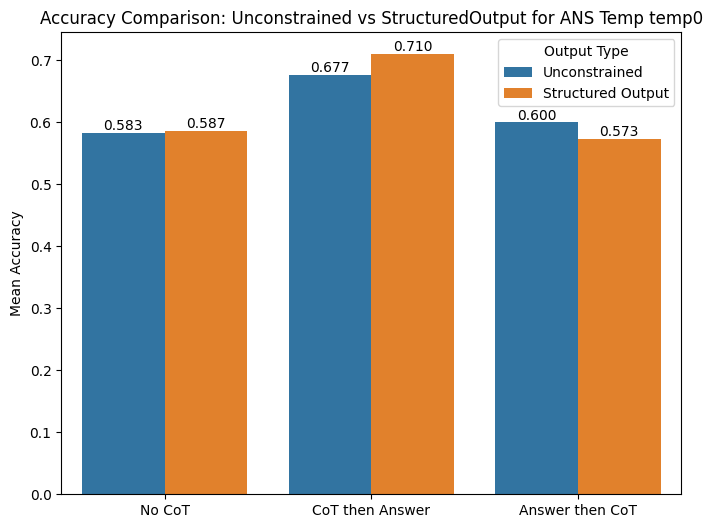

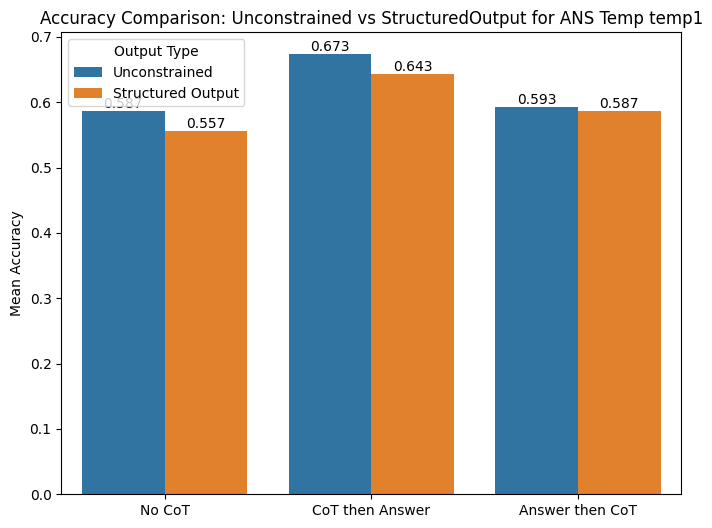

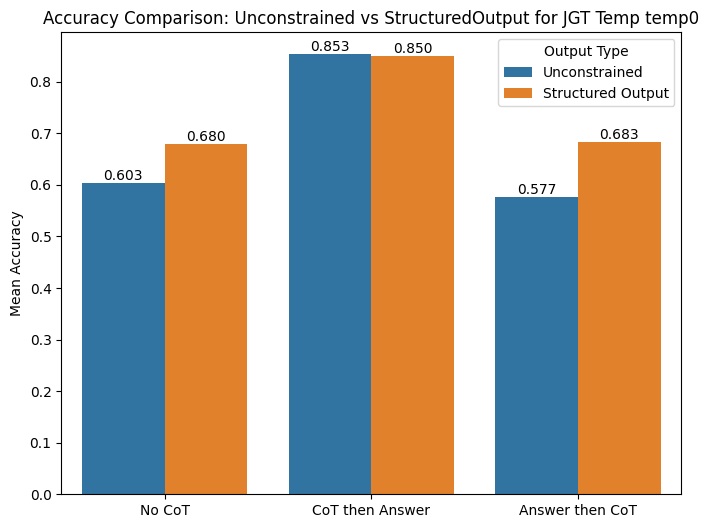

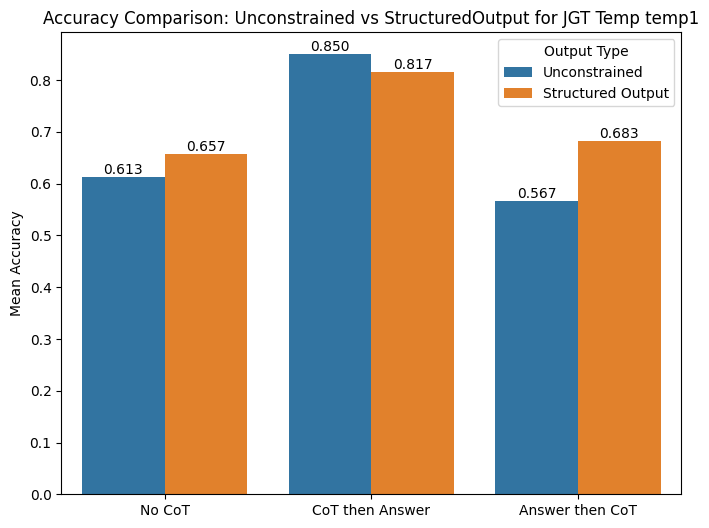

In [149]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import FixedLocator

# Function to classify schema names as "Unconstrained" or "StructuredOutput"
def classify_schema(schema_name):
    if schema_name == 'NoSchema':
        return 'Unconstrained'
    else:
        return 'Structured Output'

# Mapping for renaming CoT types
cot_labels = {
    'cot0': 'No CoT',
    'cot1': 'CoT then Answer',
    'cot2': 'Answer then CoT'
}

# Function to plot the grouped bar graph
def plot_grouped_bars(filtered_df, ans_jgt, temp):
    plt.figure(figsize=(8, 6))
    
    # Ensure cot_type is ordered as 'cot0', 'cot1', 'cot2'
    cot_order = ['cot0', 'cot1', 'cot2']
    
    # Map schema_name to either "Unconstrained" or "StructuredOutput"
    filtered_df['schema_group'] = filtered_df['schema_name'].apply(classify_schema)
    
    # Create the bar plot comparing "Unconstrained" vs "StructuredOutput"
    ax = sns.barplot(
        x='cot_type', y='accuracy_mean', hue='schema_group', data=filtered_df,
        hue_order=['Unconstrained', 'Structured Output'],  # Only two categories
        order=cot_order,  # Keep CoT types ordered
        dodge=True
    )
    
    # Add text annotations for each bar using ax.bar_label
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', fontsize=10)

    # Set custom x-tick labels with a FixedLocator
    ax.set_xticks(range(len(cot_order)))  # Ensure correct number of ticks
    ax.set_xticklabels([cot_labels[label] for label in cot_order])

    # Set the title and labels
    plt.title(f'Accuracy Comparison: Unconstrained vs StructuredOutput for {ans_jgt.upper()} Temp {temp}')
    plt.ylabel('Mean Accuracy')
    # plt.xlabel('CoT Type')
    plt.xlabel('')
    plt.xticks(rotation=0)
    plt.legend(title='Output Type')  # Rename legend title to be clearer
    plt.show()

# Loop over ans/jgt and temperature, and plot cot0, cot1, cot2 in one figure
for ans_jgt in ['ans', 'jgt']:
    for temp in ['temp0', 'temp1']:
        # Filter for ans_jgt and temperature
        filtered_df = merged_df[
            (merged_df['prompt_template'].str.contains(f"{ans_jgt}")) &
            (merged_df['temperature'] == temp) &
            (merged_df['role'].isin({"no_role", "expert"}))
        ].copy()
        
        # Replace schema_name with title case labels
        filtered_df['schema_name'] = filtered_df['schema_name'].map(schema_mapping)

        # Add CoT type as a separate column (cot0, cot1, cot2)
        filtered_df['cot_type'] = filtered_df['prompt_template'].apply(lambda x: x.split('_')[-1])

        # Plot grouped bars for each combination of ans/jgt and temperature
        plot_grouped_bars(filtered_df, ans_jgt, temp)


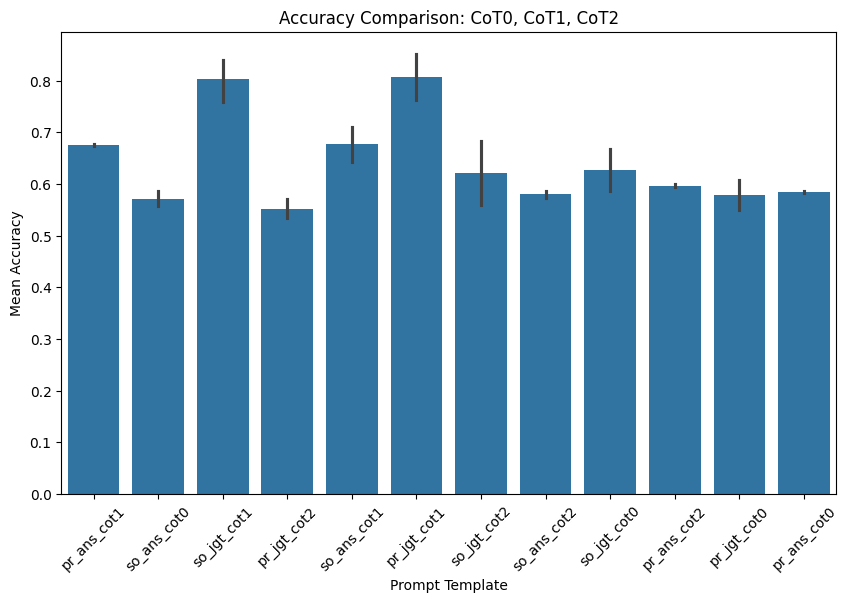

In [120]:
# Filter by prompt_template containing 'cot'
cot_df = merged_df[merged_df['prompt_template'].str.contains('cot')]

# Create bar plot comparing cot0, cot1, and cot2
plt.figure(figsize=(10, 6))
sns.barplot(x='prompt_template', y='accuracy_mean', data=cot_df)
plt.title('Accuracy Comparison: CoT0, CoT1, CoT2')
plt.xticks(rotation=45)
plt.ylabel('Mean Accuracy')
plt.xlabel('Prompt Template')
plt.show()


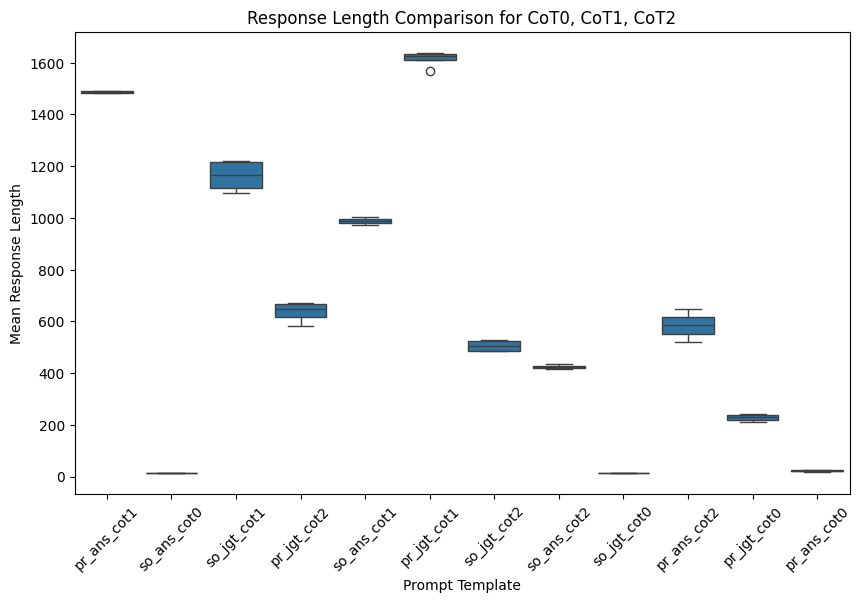

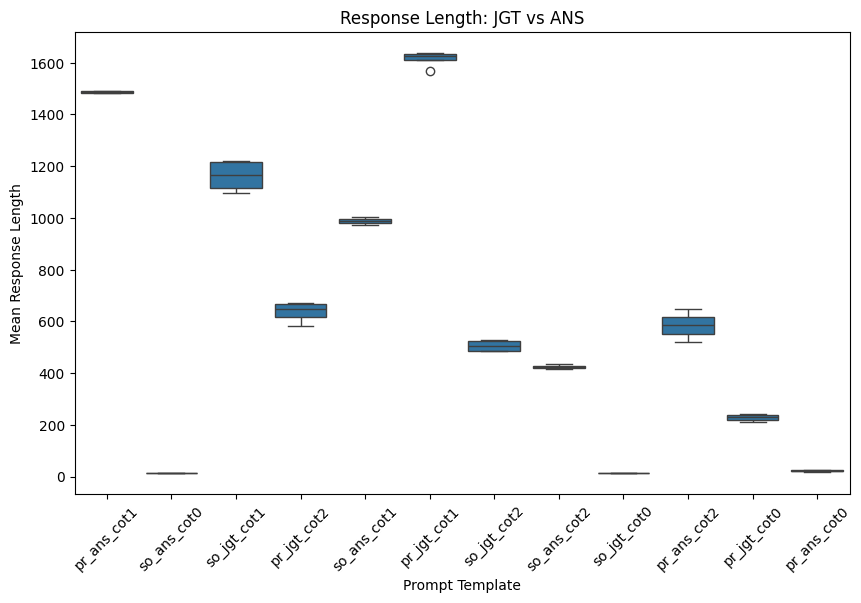

In [123]:
# Compare response lengths for CoT0, CoT1, CoT2
plt.figure(figsize=(10, 6))
sns.boxplot(x='prompt_template', y='response_length_mean_0', data=merged_df)
plt.title('Response Length Comparison for CoT0, CoT1, CoT2')
plt.xticks(rotation=45)
plt.ylabel('Mean Response Length')
plt.xlabel('Prompt Template')
plt.show()

# Compare JGT vs ANS response lengths
plt.figure(figsize=(10, 6))
sns.boxplot(x='prompt_template', y='response_length_mean_0', data=merged_df[merged_df['prompt_template'].str.contains('jgt|ans')])
plt.title('Response Length: JGT vs ANS')
plt.xticks(rotation=45)
plt.ylabel('Mean Response Length')
plt.xlabel('Prompt Template')
plt.show()


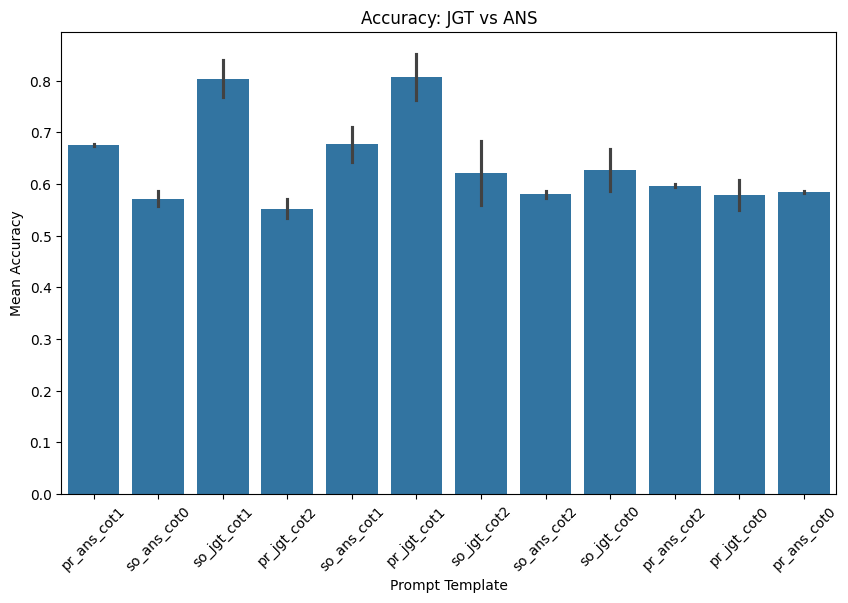

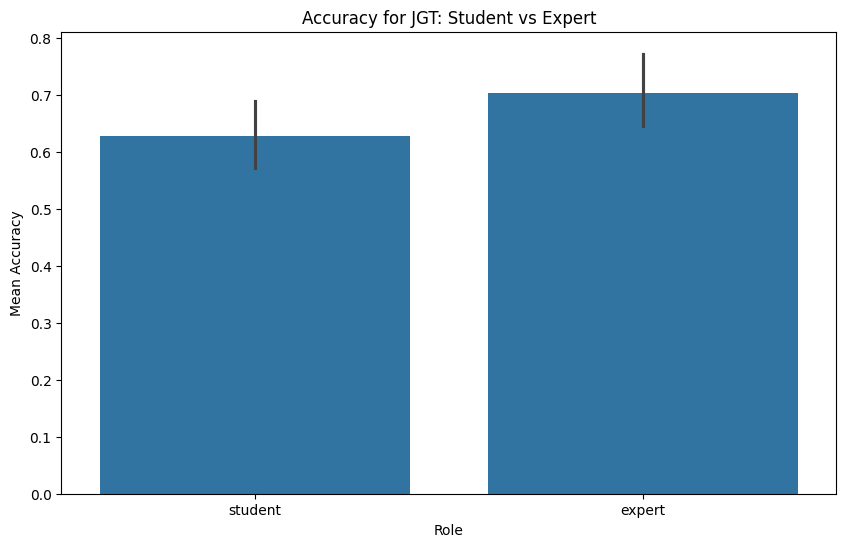

In [125]:
# Compare JGT vs ANS
jgt_ans_df = merged_df[merged_df['prompt_template'].str.contains('jgt|ans')]

plt.figure(figsize=(10, 6))
sns.barplot(x='prompt_template', y='accuracy_mean', data=jgt_ans_df)
plt.title('Accuracy: JGT vs ANS')
plt.xticks(rotation=45)
plt.ylabel('Mean Accuracy')
plt.xlabel('Prompt Template')
plt.show()

# Compare accuracy for JGT with different roles (student, expert)
jgt_df = merged_df[merged_df['prompt_template'].str.contains('jgt')]
plt.figure(figsize=(10, 6))
sns.barplot(x='role', y='accuracy_mean', data=jgt_df)
plt.title('Accuracy for JGT: Student vs Expert')
plt.ylabel('Mean Accuracy')
plt.xlabel('Role')
plt.show()


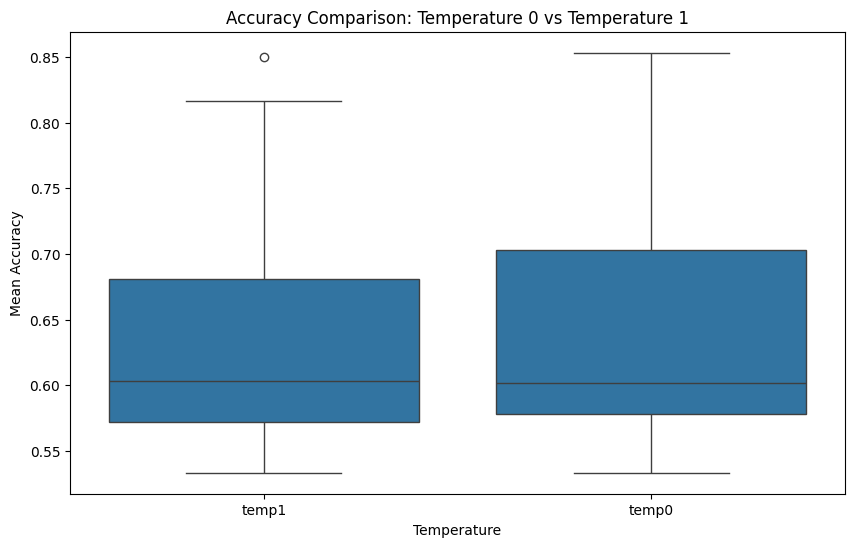

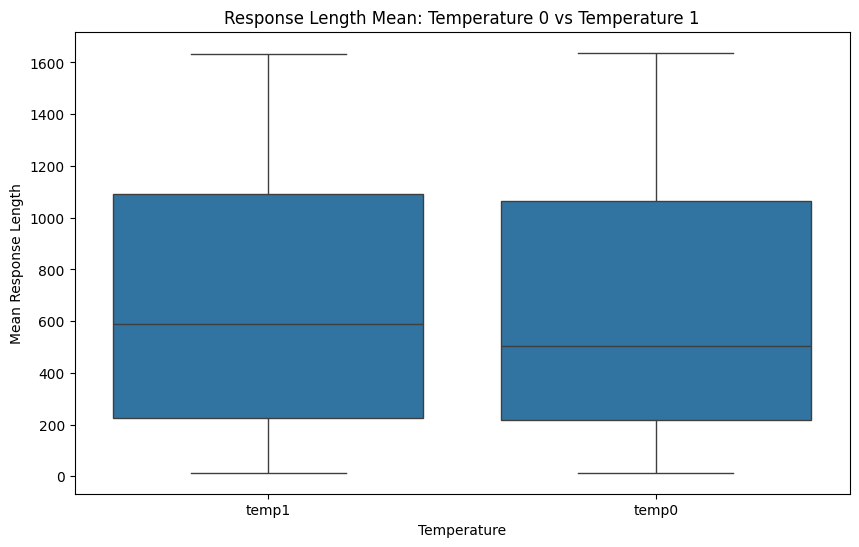

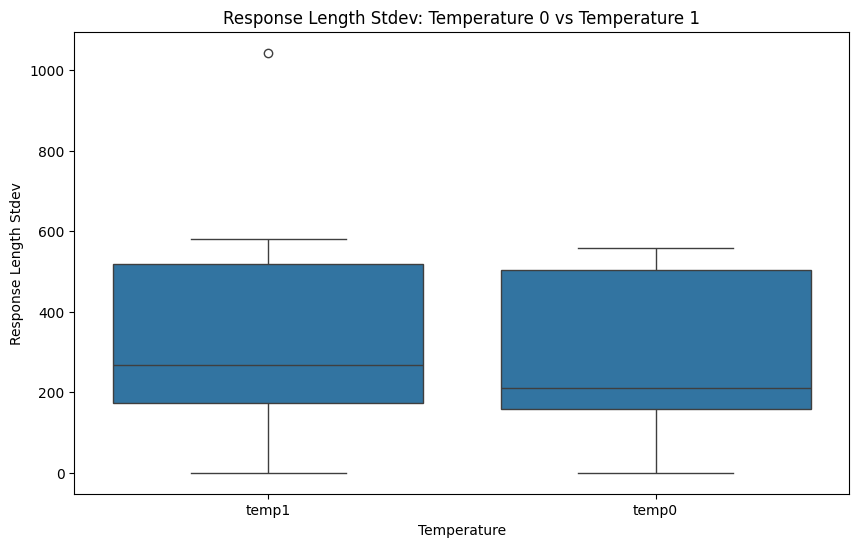

In [127]:
# Compare accuracy by temperature
plt.figure(figsize=(10, 6))
sns.boxplot(x='temperature', y='accuracy_mean', data=merged_df)
plt.title('Accuracy Comparison: Temperature 0 vs Temperature 1')
plt.ylabel('Mean Accuracy')
plt.xlabel('Temperature')
plt.show()

# Compare response length mean by temperature
plt.figure(figsize=(10, 6))
sns.boxplot(x='temperature', y='response_length_mean_0', data=merged_df)
plt.title('Response Length Mean: Temperature 0 vs Temperature 1')
plt.ylabel('Mean Response Length')
plt.xlabel('Temperature')
plt.show()

# Compare response length stdev by temperature
plt.figure(figsize=(10, 6))
sns.boxplot(x='temperature', y='response_length_stdev_0', data=merged_df)
plt.title('Response Length Stdev: Temperature 0 vs Temperature 1')
plt.ylabel('Response Length Stdev')
plt.xlabel('Temperature')
plt.show()
